In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import inspect

from datasets import load_dataset, DatasetDict, Dataset

In [2]:
connection = sqlite3.connect("crypto-news.db")
# cursorObj = connection.cursor()
# cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursorObj.fetchall())


In [3]:
train_df = pd.read_sql_query("SELECT * from train", connection)
val_df = pd.read_sql_query("SELECT * from validation", connection)
test_df = pd.read_sql_query("SELECT * from test", connection)

train_df.shape, val_df.shape, test_df.shape

((24829, 9), (4966, 9), (1242, 9))

In [4]:
def create_grid(n_rows, n_columns):
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_columns, figsize=(n_columns * 5, n_rows * 4)
    )
    return fig, axes.flatten()

In [42]:
# fig, axes = create_grid(n_rows=3, n_columns=3)

# subjects = [train_df.subject.value_counts(), val_df.subject.value_counts(), test_df.subject.value_counts()]
# sentiments = [train_df.sentiment.value_counts(), val_df.sentiment.value_counts(), test_df.sentiment.value_counts()]
# subjectivities = [train_df.subjectivity, val_df.subjectivity, test_df.subjectivity]

# axes[0].bar(subjects[0].index, subjects[0].values)
# axes[0].set_title("Subject")
# axes[0].set_ylabel("Train")
# axes[0].set_xticklabels([])
# axes[0].set_xticks([])

# axes[3].bar(subjects[1].index, subjects[1].values)
# axes[3].set_ylabel("Validataion")
# axes[3].set_xticklabels([])
# axes[3].set_xticks([])

# axes[6].bar(subjects[2].index, subjects[2].values)
# axes[6].set_ylabel("Test")
# axes[6].set_xticks(axes[6].get_xticks())
# axes[6].set_xticklabels(subjects[2].index, rotation=90)

# axes[1].bar(sentiments[0].index, sentiments[0].values)
# axes[1].set_title("Sentiment")
# axes[1].set_xticklabels([])
# axes[1].set_xticks([])

# axes[4].bar(sentiments[1].index, sentiments[1].values)
# axes[4].set_xticklabels([])
# axes[4].set_xticks([])

# axes[7].bar(sentiments[2].index, sentiments[2].values)
# axes[7].set_xticks(axes[7].get_xticks())
# axes[7].set_xticklabels(sentiments[2].index, rotation=90)

# axes[2].hist(subjectivities[0])
# axes[2].set_title("Subjectivity")
# axes[2].set_xticklabels([])
# axes[2].set_xticks([])

# axes[5].hist(subjectivities[1])
# axes[5].set_xticklabels([])
# axes[5].set_xticks([])

# axes[8].hist(subjectivities[2])

# plt.show()



In [5]:
dataset = {
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
}
dataset

{'train': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 24829
 }),
 'validation': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 4966
 }),
 'test': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 1242
 })}

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
PAD_TOKEN = "<pad>"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" #if available
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Embedding(32008, 2048)

In [53]:
# tokenizer.bos_token, tokenizer.bos_token_id
# tokenizer.eos_token, tokenizer.eos_token_id
# tokenizer.pad_token, tokenizer.pad_token_id
# PAD_TOKEN in tokenizer.get_vocab()

In [7]:
def format_example(example):
    return inspect.cleandoc(f"""
    ### Title:
    {example["title"]}
    ### Text:
    {example["text"]}
    ### Prediction:
    subject: {example["subject"]}
    sentiment: {example["sentiment"]}
    """)
print(format_example(dataset["train"][0]))

### Title:
IDEG Appoints Coinbase Prime as Strategic Partner to Launch Ethereum Enhanced Portfolio
### Text:
IDEG's new investment vehicle is part of its thematic product suite - TIMES and it comes following a partnership with Coinbase.
### Prediction:
subject: ethereum
sentiment: positive


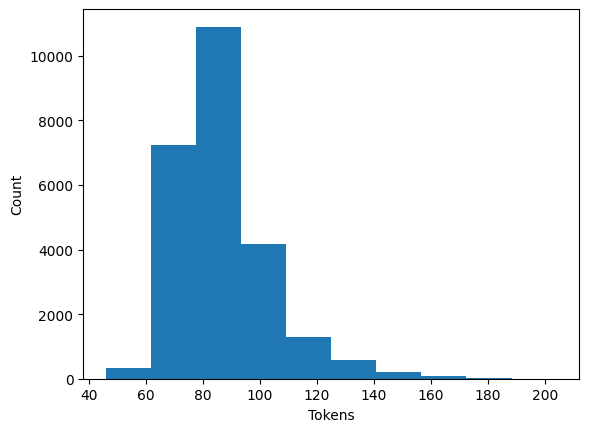

In [8]:
# Shows the tokenizer histogram of training set

token_counts = []
for example in dataset["train"]:
    token_counts.append(
        len(tokenizer(format_example(example), add_special_tokens=True, return_attention_mask=False)["input_ids"])
    )
plt.hist(token_counts)
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

In [9]:
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [10]:
#model.config
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32008, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [11]:
# LoRA setup, use model.print_trainable_parameters() to get augmented model

from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig (
    r=128,
    lora_alpha=128,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj"
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 100,925,440 || all params: 1,201,006,592 || trainable%: 8.403404333687455


In [12]:
# Training 

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from torch.utils.data import DataLoader

response_template_with_context = "\n### Prediction:"

#subject: {example["subject"]}
#sentiment: {example["sentiment"]}, last two, ignore Title, Text
response_template_ids = tokenizer.encode(response_template_with_context, add_special_tokens=False)[2:]

# Data collator used for language modeling that masks entire words.
# Data collators are objects that will form a batch by using a list of dataset elements as input.
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

examples = [format_example(dataset["train"][0])]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [14]:
batch["labels"]

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,    13, 16009, 29901, 11314,   406,   398,
            13, 18616,  2073, 29901,  6374]])

In [15]:
# Traininig Arguments

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="adamw_torch",
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    #bf16=True,  # or fp16=True,
    save_strategy="epoch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=123,
)

In [16]:
def format_prompts(example):
    output_texts = []
    for i in range(len(example["title"])):
        text = inspect.cleandoc(f"""
        ### Title:
        {example["title"][i]}
        ### Text:
        {example["text"][i]}
        ### Prediction:
        subject: {example["subject"][i]}
        sentiment: {example["sentiment"][i]}
        """)
        output_texts.append(text)
    return output_texts

In [17]:
# trainer 

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    max_seq_length=1024,
    formatting_func=format_prompts,
    data_collator=collator
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/24829 [00:00<?, ? examples/s]

Map:   0%|          | 0/4966 [00:00<?, ? examples/s]

In [18]:
# run training
trainer.train()

Step,Training Loss,Validation Loss
311,0.141200,0.146068
622,0.109500,0.115414
933,0.089000,0.102901
1244,0.087500,0.091207


/Users/royzheng/workArea/workspace/llm-playground/env/lib/python3.10/site-packages/peft/utils/save_and_load.py:160: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=1552, training_loss=0.12305564889396281, metrics={'train_runtime': 39360.9115, 'train_samples_per_second': 0.631, 'train_steps_per_second': 0.039, 'total_flos': 1.7664047648464896e+16, 'train_loss': 0.12305564889396281, 'epoch': 1.0})

In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir experiments/runs

python(43613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
